In [14]:
from scipy.stats import norm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[8,6]

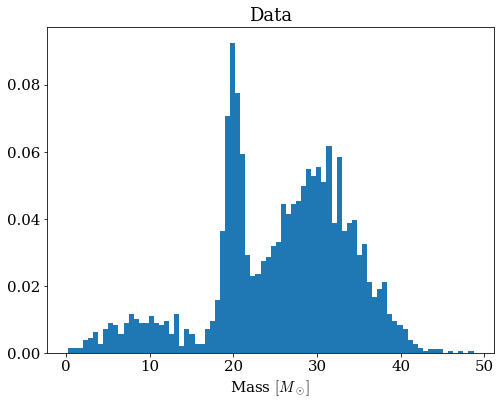

In [66]:
data=np.load('formationchannels.npy')

#let's have a look at the data
N_bin=80
plt.hist(data[data>0], density=True, bins=N_bin)
plt.xlabel('Mass $[M_\odot]$')
plt.title('Data')
plt.show()

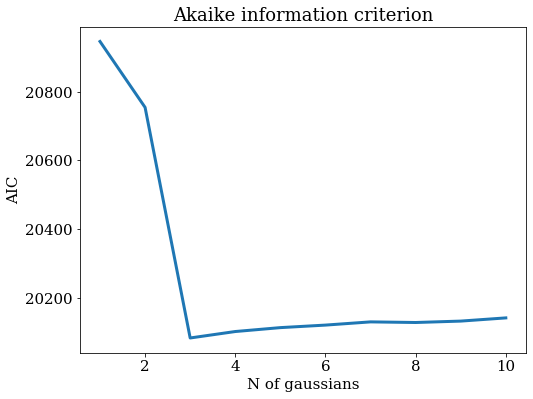

The best model is the one with  3  components


In [123]:
#use now Gaussian Mixture
components=np.linspace(1,10,10, dtype=int)

gm = np.array([GaussianMixture(n_components=c).fit(data) for c in components])

#compute the AIC and plot its values as a function of the number of the gaussian
AIC=np.empty(len(components))
for i in range(len(components)):
    AIC[i] = gm[i].aic(data)
    
plt.plot(components, AIC, lw=3)
plt.ylabel('AIC')
plt.xlabel('N of gaussians')
plt.title('Akaike information criterion')
plt.show()

min_i=np.argmin(AIC)
best_model=components[min_i]

print("The best model is the one with ", best_model, " components")

GaussianMixture(n_components=3)


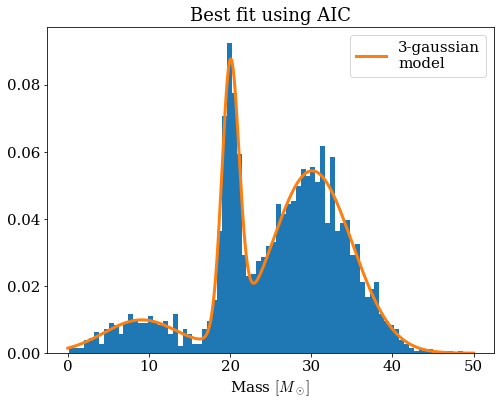

In [124]:
#plot now the fit, to visually verify its correctness

best_model=gm[min_i]
print(best_model)

plt.hist(data[data>0], density=True, bins=N_bin)
x=np.linspace(0,50,1000)

plt.plot(x, np.exp(best_model.score_samples(x[:, np.newaxis])), lw=3, label='3-gaussian\nmodel')
plt.xlabel('Mass $[M_\odot]$')
plt.title('Best fit using AIC')
plt.legend()
plt.show()

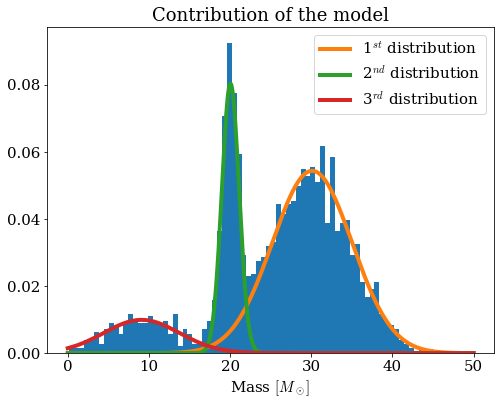

In [125]:
#plot the contribution of each gaussian distribution

contr=best_model.predict_proba(x.reshape(-1, 1))
pdf=np.exp(best_model.score_samples(x[:, np.newaxis]))
pdf_contr=contr*pdf[:, np.newaxis]

plt.hist(data[data>0], density=True, bins=N_bin)

plt.plot(x, pdf_contr[:,0], lw=4, label='1$^{st}$ distribution')
plt.plot(x, pdf_contr[:,1], lw=4, label='2$^{nd}$ distribution')
plt.plot(x, pdf_contr[:,2], lw=4, label='3$^{rd}$ distribution')
plt.xlabel('Mass $[M_\odot]$')
plt.title('Contribution of the model')
plt.legend()
plt.show()